In [5]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [2]:
try:
    nltk.download('punkt_tab', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

In [3]:
with open("/content/nlu dataset.json") as f:
    data = json.load(f)

In [4]:
print("Dataset loaded successfully!")
print("Top-level keys:", list(data.keys()))

Dataset loaded successfully!
Top-level keys: ['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train']


**TEXT PREPROCESSING**

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [7]:
def extract_data(dataset):
    """Extract all texts and create binary labels"""
    in_scope_texts = []
    out_scope_texts = []

    for split in ['train', 'val', 'test']:
        if split in dataset:
            split_data = dataset[split]
            for item in split_data:
                if len(item) >= 2:
                    in_scope_texts.append(item[0])

    for split in ['oos_train', 'oos_val', 'oos_test']:
        if split in dataset:
            split_data = dataset[split]
            for item in split_data:
                if len(item) >= 2:
                    out_scope_texts.append(item[0])

    return in_scope_texts, out_scope_texts

in_scope_texts, out_scope_texts = extract_data(data)

print(f"In-scope samples: {len(in_scope_texts)}")
print(f"Out-of-scope samples: {len(out_scope_texts)}")

In-scope samples: 22500
Out-of-scope samples: 1200


In [8]:
X_texts = in_scope_texts + out_scope_texts
y_labels = [1] * len(in_scope_texts) + [0] * len(out_scope_texts)

In [9]:
print(f"\nTotal samples: {len(X_texts)}")
print(f"Labels distribution:")
print(f"  - In-scope (1): {sum(y_labels)}")
print(f"  - Out-of-scope (0): {len(y_labels) - sum(y_labels)}")


Total samples: 23700
Labels distribution:
  - In-scope (1): 22500
  - Out-of-scope (0): 1200


Text(0.5, 1.0, 'Dataset Distribution')

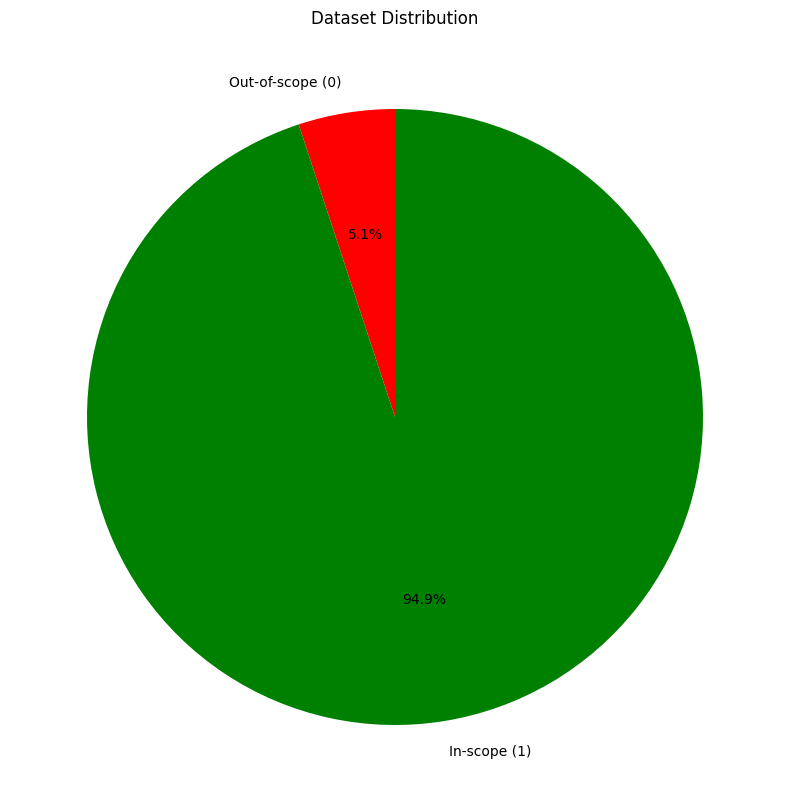

In [35]:
plt.figure(figsize=(15, 10))

labels = ['Out-of-scope (0)', 'In-scope (1)']
counts = [len(y_labels) - sum(y_labels), sum(y_labels)]
colors = ['red', 'green']
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Distribution')

**Text Processing**

In [10]:
X_clean = [clean_text(text) for text in X_texts]
print("\nSample processed texts:")
for i in range(3):
    print(f"Original: {X_texts[i]}")
    print(f"Cleaned:  {X_clean[i]}")
    print(f"Label:    {y_labels[i]} ({'in-scope' if y_labels[i] == 1 else 'out-of-scope'})")
    print()



Sample processed texts:
Original: what expression would i use to say i love you if i were an italian
Cleaned:  expression would use say love italian
Label:    1 (in-scope)

Original: can you tell me how to say 'i do not speak much spanish', in spanish
Cleaned:  tell say speak much spanish spanish
Label:    1 (in-scope)

Original: what is the equivalent of, 'life is good' in french
Cleaned:  equivalent life good french
Label:    1 (in-scope)



In [11]:
for i in range(3):
    print(f"Original: {X_texts[i]}")
    print(f"Cleaned:  {X_clean[i]}")
    print(f"Label:    {y_labels[i]} ({'in-scope' if y_labels[i] == 1 else 'out-of-scope'})")
    print()

Original: what expression would i use to say i love you if i were an italian
Cleaned:  expression would use say love italian
Label:    1 (in-scope)

Original: can you tell me how to say 'i do not speak much spanish', in spanish
Cleaned:  tell say speak much spanish spanish
Label:    1 (in-scope)

Original: what is the equivalent of, 'life is good' in french
Cleaned:  equivalent life good french
Label:    1 (in-scope)



**Feature Extraction**

In [12]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_features = vectorizer.fit_transform(X_clean)
print(f"Feature matrix shape: {X_features.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Feature matrix shape: (23700, 3000)
Vocabulary size: 3000


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

In [14]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training labels - In-scope: {sum(y_train)}, Out-of-scope: {len(y_train) - sum(y_train)}")
print(f"Test labels - In-scope: {sum(y_test)}, Out-of-scope: {len(y_test) - sum(y_test)}")


Training set: 18960 samples
Test set: 4740 samples
Training labels - In-scope: 18000, Out-of-scope: 960
Test labels - In-scope: 4500, Out-of-scope: 240


In [15]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

print("Training Random Forest model...")
model.fit(X_train, y_train)

Training Random Forest model...


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [16]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

Accuracy: 0.7103
AUC Score: 0.8457


In [18]:
print(classification_report(y_test, y_pred, target_names=['Out-of-scope (0)', 'In-scope (1)']))


                  precision    recall  f1-score   support

Out-of-scope (0)       0.13      0.82      0.22       240
    In-scope (1)       0.99      0.70      0.82      4500

        accuracy                           0.71      4740
       macro avg       0.56      0.76      0.52      4740
    weighted avg       0.94      0.71      0.79      4740



In [19]:
confidence_scores = np.max(y_pred_proba, axis=1)

In [20]:
print(f"Average confidence: {np.mean(confidence_scores):.4f}")
print(f"Min confidence: {np.min(confidence_scores):.4f}")
print(f"Max confidence: {np.max(confidence_scores):.4f}")


Average confidence: 0.5418
Min confidence: 0.5000
Max confidence: 0.7875


In [23]:
high_conf_mask = confidence_scores > 0.5
print(f"High confidence predictions (>0.5): {np.sum(high_conf_mask)} out of {len(confidence_scores)}")


High confidence predictions (>0.5): 4740 out of 4740


In [24]:
def predict_with_confidence(text):
    clean_text_input = clean_text(text)
    X_input = vectorizer.transform([clean_text_input])
    prediction = model.predict(X_input)[0]
    probabilities = model.predict_proba(X_input)[0]
    confidence = max(probabilities)

    return {
        'text': text,
        'prediction': prediction,
        'label': 'in-scope' if prediction == 1 else 'out-of-scope',
        'confidence': confidence,
        'probabilities': probabilities
    }
test_examples = [
    "I want to book a flight",
    "What's the weather today?",
    "Tell me a joke about aliens",
    "Can you help me with my account?",
    "What's the meaning of life?",
    "I need to cancel my subscription",
    "Sing me a song in Japanese",
    "How do I reset my password?",
    "What's 2+2?",
    "I love pizza"
]
for example in test_examples:
    result = predict_with_confidence(example)
    print(f"Text: '{result['text']}'")
    print(f"  Prediction: {result['label']} (confidence: {result['confidence']:.3f})")
    print(f"  Probabilities: Out-of-scope={result['probabilities'][0]:.3f}, In-scope={result['probabilities'][1]:.3f}")

Text: 'I want to book a flight'
  Prediction: in-scope (confidence: 0.531)
  Probabilities: Out-of-scope=0.469, In-scope=0.531
Text: 'What's the weather today?'
  Prediction: out-of-scope (confidence: 0.519)
  Probabilities: Out-of-scope=0.519, In-scope=0.481
Text: 'Tell me a joke about aliens'
  Prediction: out-of-scope (confidence: 0.505)
  Probabilities: Out-of-scope=0.505, In-scope=0.495
Text: 'Can you help me with my account?'
  Prediction: in-scope (confidence: 0.557)
  Probabilities: Out-of-scope=0.443, In-scope=0.557
Text: 'What's the meaning of life?'
  Prediction: in-scope (confidence: 0.521)
  Probabilities: Out-of-scope=0.479, In-scope=0.521
Text: 'I need to cancel my subscription'
  Prediction: in-scope (confidence: 0.542)
  Probabilities: Out-of-scope=0.458, In-scope=0.542
Text: 'Sing me a song in Japanese'
  Prediction: in-scope (confidence: 0.503)
  Probabilities: Out-of-scope=0.497, In-scope=0.503
Text: 'How do I reset my password?'
  Prediction: out-of-scope (confiden

Text(158.22222222222223, 0.5, 'Actual')

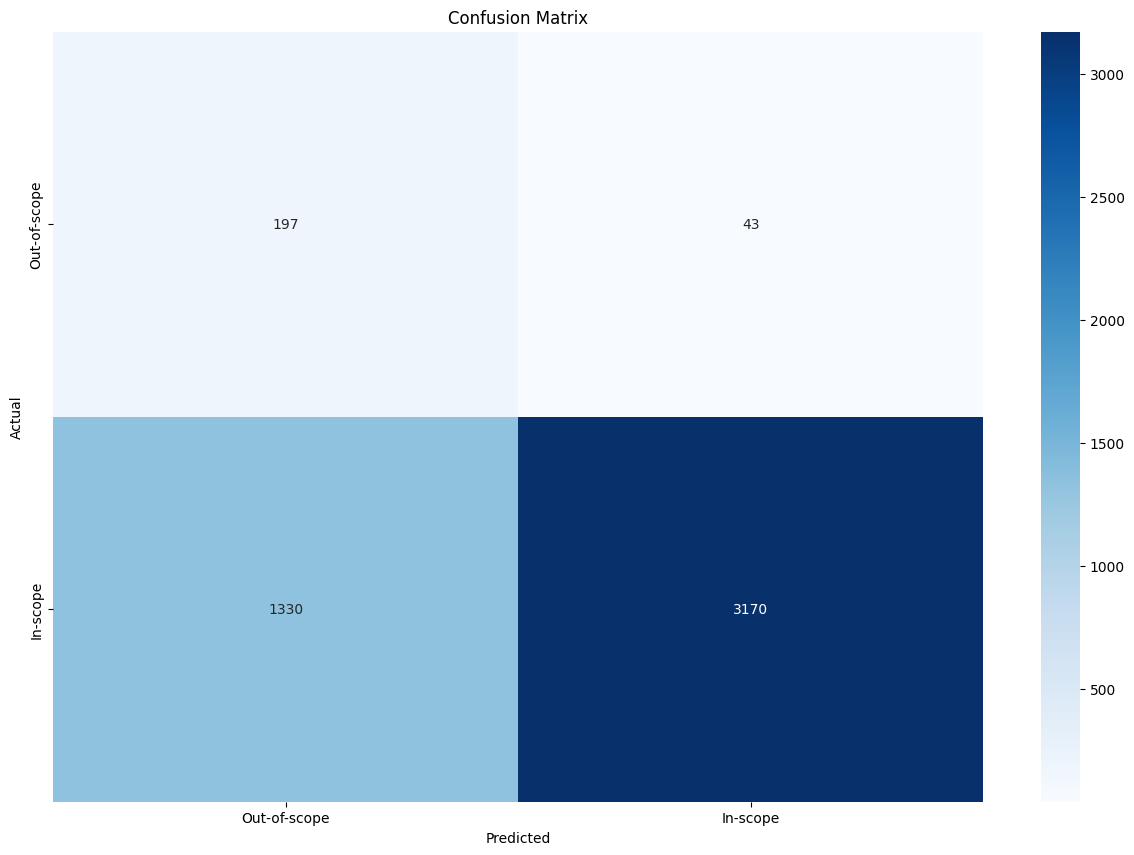

In [36]:
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Out-of-scope', 'In-scope'],
            yticklabels=['Out-of-scope', 'In-scope'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

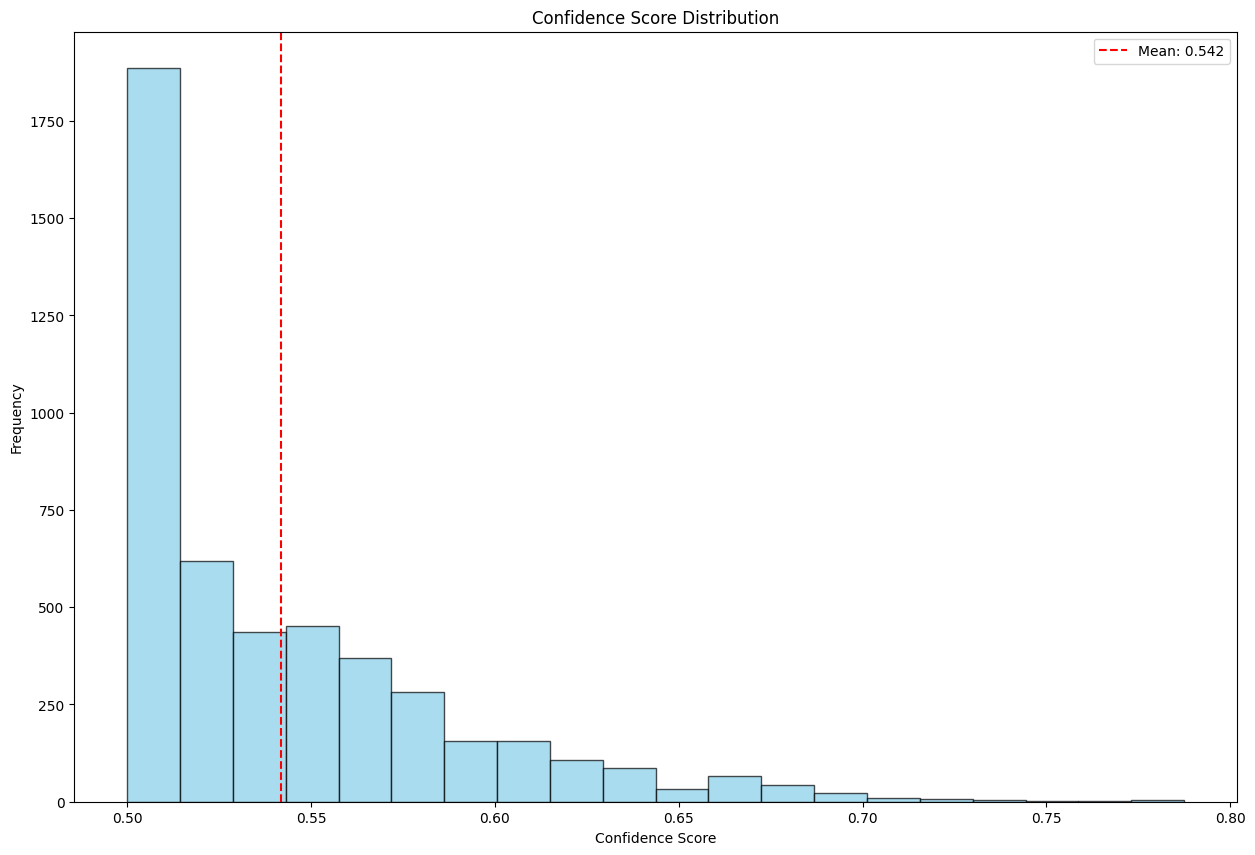

In [38]:
plt.figure(figsize=(15, 10))
plt.hist(confidence_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', label=f'Mean: {np.mean(confidence_scores):.3f}')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.legend()
